In [2]:
import os
## For setup
import torch
from configs.get_config import get_config_from_yml
from GINN.shape_boundary_helper import ShapeBoundaryHelper
from GINN.helpers.mp_manager import MPManager
from GINN.helpers.timer_helper import TimerHelper
from GINN.morse.scc_surfacenet_manager import SCCSurfaceNetManager
from GINN.problem_sampler import ProblemSampler
from GINN.visualize.plotter_3d import Plotter3d
from train.train_utils.autoclip import AutoClip
from utils import get_model, get_stateless_net_with_partials

## For extracting and plotting a mesh
import k3d
from notebooks.notebook_utils import get_mesh_for_latent

## For running a training loop
import einops
from tqdm import trange
from models.model_utils import tensor_product_xz
from train.losses import closest_shape_diversity_loss, eikonal_loss, envelope_loss, interface_loss, normal_loss_euclidean, obstacle_interior_loss, strain_curvature_loss
from train.train_utils.latent_sampler import sample_new_z
from utils import set_all_seeds

import ipywidgets
import os
import numpy as np

In [3]:
torch.cuda.empty_cache()  # Clear cached memory before marching cubes

cuda_dev = "0"
os.environ['CUDA_VISIBLE_DEVICES'] = cuda_dev
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

## Read the config
# yml_path = '_quickstart/config_3d_cubehole.yml'
# config['device'] = device

def load_model(config_path, params_path, bx=1, by=1, bz=1, cx=0, cy=0, cz=0):
    config = get_config_from_yml(yml_path)
    config['device'] = device

    # with open('data.yml', 'r') as file:
    #     loaded_data = yaml.safe_load(file)

    model = get_model(config)
    netp = get_stateless_net_with_partials(model, use_x_and_z_arg=config['use_x_and_z_arg'])
    model.load_state_dict(torch.load(params_path, map_location=device))

    # z = loaded_data['z']    
    # config['bounds'] = loaded_data['bounds']
    config['bounds'] = torch.tensor([[cx-bx, cx+bx], [cy-by, cy+by], [cz-bz, cz+bz]]).to(device)

    return config, model, netp

In [17]:
# plots = [k3d.plot()]
# mesh = None

def update_plot(fig, config, model, netp, prev_mesh=None, display=True):
    # bounds = config['bounds']
    bounds = np.load(os.path.join(config['dataset_dir'], "bounds.npy"))

    # z = z.view(-1)
    z = torch.tensor([-1])

    mesh_checkpoint = get_mesh_for_latent(netp.f_, netp.params_, z, config['bounds'], mc_resolution=32, device=device, chunks=1)
    mesh_plot = k3d.mesh(*mesh_checkpoint, color=0xff0000, side='double')
    if prev_mesh: fig -= prev_mesh
    fig += mesh_plot

    if display:
        fig.display()

    return mesh_plot

plot = k3d.plot()
plot.camera = [
    2.328582799555154,
    -3.7736728128045924,
    2.695248813974635,
    0,
    0,
    -0.0031126737594604492,
    -0.2583870366446242,
    0.3948189169598876,
    0.881676903465569
]

yml_path = '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-03-31_12-04-49_Area_1/15_table/config.yml'
params_path = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-03-22_18-37-18_Area_1/15_table/cond_siren/2025_03_22-18_39_54/2025_03_22-18_39_56-p281m7ag_best_248.pth"
b = 5
config, model, netp = load_model(yml_path, params_path, bx=b, by=b, bz=b, cx=0, cy=0, cz=0)
# config, model, netp = load_model(yml_path, params_path, bx=0.6, by=1, bz=0.3)
update_plot(plot, config, model, netp, display=False)

plot.display()

Output()

In [11]:
plot.camera

[2.328582799555154,
 -3.7736728128045924,
 2.695248813974635,
 0,
 0,
 -0.0031126737594604492,
 -0.2583870366446242,
 0.3948189169598876,
 0.881676903465569]

In [12]:
savedir = "animations/screenshots/screenshots_horse"
config_path = '/scratch/rhm4nj/cral/cral-ginn/ginn/configs/horse.yml'
params_path = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/cond_siren/2024_11_18-15_24_24"
b = .5

if not os.path.exists(savedir):
    os.makedirs(savedir)

model_files = os.listdir(params_path)
model_files = sorted(model_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
model_pth_paths = [os.path.join(params_path, p) for p in model_files]
print(model_pth_paths)

# # mesh = None
# plot = k3d.plot()
# plot.camera = [2.158411992944893, -3.23761798941734, 0.2158411992944912, 0, 0, 0, 0, 0, 1]
# plot.camera_auto_fit = False
# plot.grid_auto_fit = False
# plot.display()

out = ipywidgets.Output()

@plot.yield_screenshots
def coroutine():    
    prev_mesh = None
    for i, model_pth_path in enumerate(model_pth_paths):
        epoch_str = model_pth_path.split('_')[-1].split('.')[0]
        if int(epoch_str) < 1000:
            epoch_str = "0" + epoch_str

        to_save = os.path.join(savedir, f'screenshot_{epoch_str}.png')

        config, model, netp = load_model(config_path, model_pth_path, bx=b, by=b, bz=b, cx=b, cy=0, cz=0)
        prev_mesh = update_plot(plot, config, model, netp, prev_mesh=prev_mesh, display=False)

        plot.fetch_screenshot()
        screenshot = yield

        with open(to_save, 'wb') as f:
            f.write(screenshot)
        with out:
            print(to_save)
    with out:
        print('done.')

coroutine()
print('loop is running in background...')
out

['/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/cond_siren/2024_11_18-15_24_24/2024_11_18-15_24_26-n1h1sab2_0.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/cond_siren/2024_11_18-15_24_24/2024_11_18-15_24_26-n1h1sab2_100.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/cond_siren/2024_11_18-15_24_24/2024_11_18-15_24_26-n1h1sab2_200.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/cond_siren/2024_11_18-15_24_24/2024_11_18-15_24_26-n1h1sab2_300.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/cond_siren/2024_11_18-15_24_24/2024_11_18-15_24_26-n1h1sab2_400.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/cond_siren/2024_11_18-15_24_24/2024_11_18-15_24_26-n1h1sab2_500.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/cond_siren/2024_11_18-15_24_24/2024_11_18-15_24_26-n1h1sab2_600.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/cond_siren/2024_11_18-15_24_24/2024_11_18-15_24_26-n1h1sab2_700.pth', '/scratch/rhm4nj/

Output()

In [13]:
from PIL import Image, ImageDraw, ImageFont
import os

# Directory with screenshots
screenshots_dir = savedir

try:
    font = ImageFont.truetype("arial.ttf", 36)  # Change this to your preferred font
except IOError:
    font = ImageFont.load_default()

for filename in os.listdir(screenshots_dir):
    number_str = filename.split('_')[-1].split('.')[0]
    
    image_path = os.path.join(screenshots_dir, filename)
    image = Image.open(image_path)
    
    draw = ImageDraw.Draw(image)
    
    text_position = (10, 10)  # Top-left corner (x, y)
    text_color = (0, 0, 0)  # White color for the text
    
    draw.text(text_position, number_str, font=font, fill=text_color)
    image.save(image_path)

    print(f"Processed: {filename}")

print("All images processed.")

Processed: screenshot_0300.png
Processed: screenshot_00.png
Processed: screenshot_0800.png
Processed: screenshot_0900.png
Processed: screenshot_1100.png
Processed: screenshot_1300.png
Processed: screenshot_0100.png
Processed: screenshot_1600.png
Processed: screenshot_0400.png
Processed: screenshot_0700.png
Processed: screenshot_0200.png
Processed: screenshot_1000.png
Processed: screenshot_1200.png
Processed: screenshot_1800.png
Processed: screenshot_0600.png
Processed: screenshot_1400.png
Processed: screenshot_1500.png
Processed: screenshot_0500.png
Processed: screenshot_1700.png
All images processed.


In [14]:
gifname = f'animations/gifs/{savedir.split("/")[-1]}.gif'
!convert -delay 60 -loop 0 {savedir}/*.png {gifname}

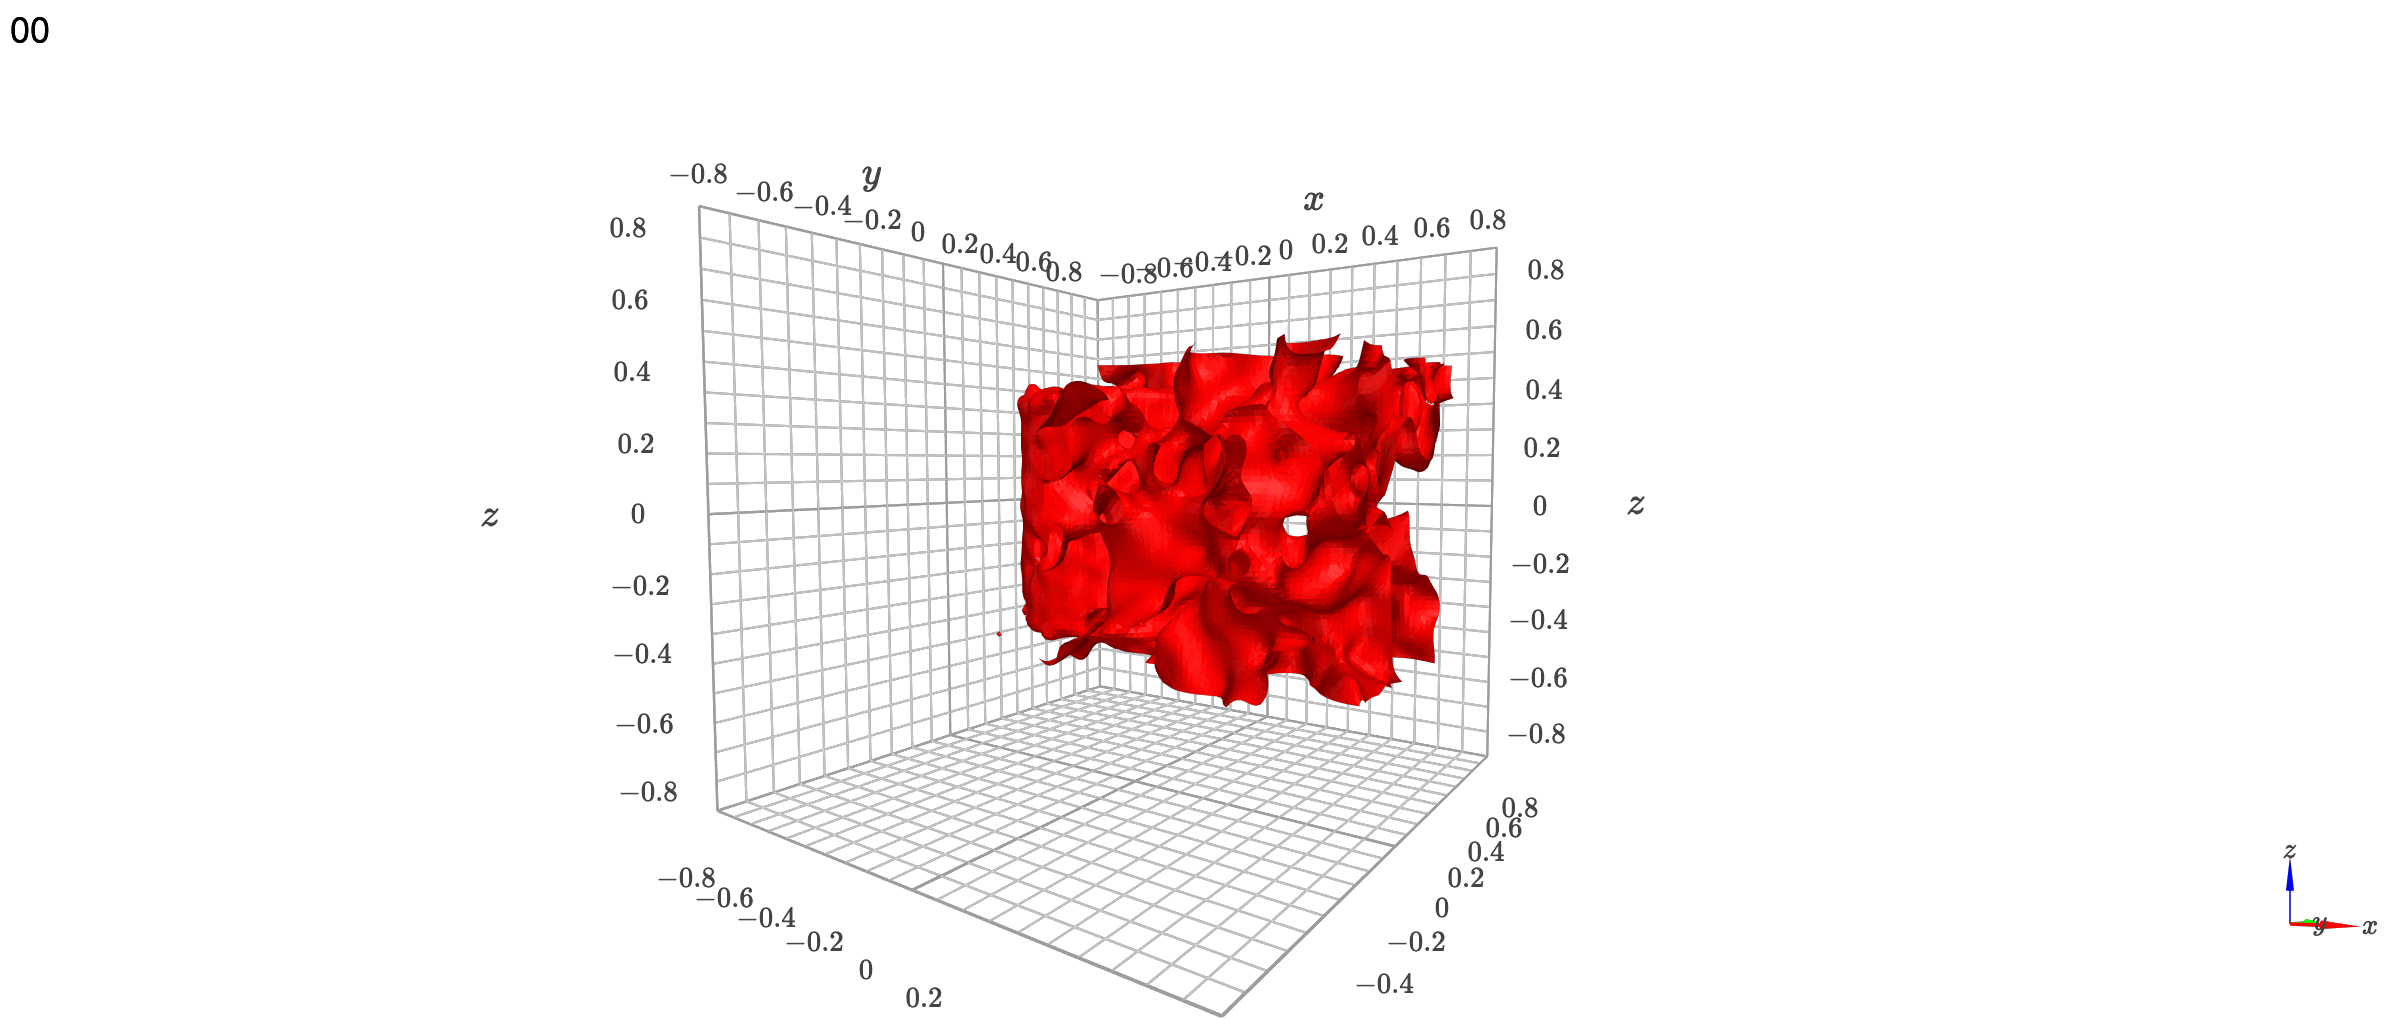

In [15]:
from IPython.display import Image
Image(gifname)